In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import json
from unidecode import unidecode
from nltk.tokenize import word_tokenize
import community 
import os
from collections import Counter
import re
import powerlaw

# Load data and create network

In [2]:
def clean_name(name):
    name = name.replace('"', '')
    return unidecode(name)

In [3]:
# Read the data from the csv file
senate_df = pd.read_csv('usa_data/senators.csv')
house_df = pd.read_csv('usa_data/house.csv')

# clean all names
senate_df['Senator'] = senate_df['Senator'].apply(clean_name)
house_df['Member'] = house_df['Member'].apply(clean_name)

senators = senate_df['Senator'].tolist()
representatives = house_df['Member'].tolist()

senators_names = [clean_name(name) for name in senators]
representatives = [clean_name(name) for name in representatives]

# remove representatives that are vacant
representatives = [x for x in representatives if x != 'Vacant']

In [4]:
# load the JSON string back into a dictionary
with open('usa_data/house_links.json', 'r') as f:
    house_links = json.loads(f.read())

with open('usa_data/senate_links.json', 'r') as f:
    senate_links = json.loads(f.read())

In [5]:
# create a graph object
congress_dict = {**house_links, **senate_links}

congress_graph = nx.DiGraph()

# add nodes to the graph
congress_graph.add_nodes_from(senators)
congress_graph.add_nodes_from(representatives)

for key, values in congress_dict.items():
    for value in values:
        congress_graph.add_edge(key, value)

party = senate_df['Party'].unique().tolist()

# add house, senate and state attributes to the nodes
for node in congress_graph.nodes():
    if node in senators:
        congress_graph.nodes[node]['chamber'] = 'Senate'
        congress_graph.nodes[node]['party'] = senate_df.loc[senate_df['Senator'] == node]['Party'].values[0]
        congress_graph.nodes[node]['state'] = senate_df.loc[senate_df['Senator'] == node]['State'].values[0]
        

    elif node in representatives:
        congress_graph.nodes[node]['chamber'] = 'House'
        congress_graph.nodes[node]['party'] = house_df.loc[house_df['Member'] == node]['Party'].values[0]
        congress_graph.nodes[node]['state'] = house_df.loc[house_df['Member'] == node]['District'].values[0]
        
        #print(house_df.loc[house_df['Member'] == node]['Party'].values)


print(congress_graph)
# to do, remove number on district

DiGraph with 533 nodes and 3026 edges


# Basic network stats

In [6]:
#print number of republican in house and senate"
print(len([node for node in congress_graph.nodes() if congress_graph.nodes[node]['party'] == 'Republican']))
print(len([node for node in congress_graph.nodes() if congress_graph.nodes[node]['party'] == 'Democratic']))
print(len([node for node in congress_graph.nodes() if congress_graph.nodes[node]['party'] != 'Republican' and congress_graph.nodes[node]['party'] != 'Democratic']))

270
258
5


In [7]:
# find most connected node based on House

# find most connected rappers from east and west coast
in_degrees = sorted(congress_graph.in_degree, key=lambda x: x[1], reverse=True)
out_degrees = sorted(congress_graph.out_degree, key=lambda x: x[1], reverse=True)

in_house = []
in_senate = []
out_house = []
out_senate = []

for node in in_degrees:
    if congress_graph.nodes[node[0]]['chamber'] == 'House':
        in_house.append(node)
    else:
        in_senate.append(node)

for node in out_degrees:
    if congress_graph.nodes[node[0]]['chamber'] == 'House':
        out_house.append(node)
    else:
        out_senate.append(node)


In [8]:
# Most connected east coast rappers
print("Top 5 highest out-degree members of house of representatives:")
for i in range(5):
    print(str(i+1)+ ")"+str(out_house[i])[1:-1])

print("\n")
print("Top 5 highest out-degree members of senate:")
for i in range(5):
    print(str(i+1)+ ")"+str(out_senate[i])[1:-1])

Top 5 highest out-degree members of house of representatives:
1)'Marjorie Taylor Greene', 34
2)'Chip Roy', 31
3)'Alexandria Ocasio-Cortez', 27
4)'Kevin McCarthy', 26
5)'Josh Gottheimer', 21


Top 5 highest out-degree members of senate:
1)'Joe Manchin', 31
2)'Chuck Schumer', 24
3)'Tom Cotton', 22
4)'Ron Wyden', 22
5)'Bernie Sanders', 22


In [9]:
# Most connected east coast rappers
print("Top 5 highest in-degree members of house of representatives:")
for i in range(5):
    print(str(i+1)+ ")"+str(in_house[i])[1:-1])

print("\n")
print("Top 5 highest in-degree members of senate:")
for i in range(5):
    print(str(i+1)+ ")"+str(in_senate[i])[1:-1])

Top 5 highest in-degree members of house of representatives:
1)'Nancy Pelosi', 100
2)'Kevin McCarthy', 71
3)'Alexandria Ocasio-Cortez', 35
4)'Marjorie Taylor Greene', 32
5)'Jim Jordan', 25


Top 5 highest in-degree members of senate:
1)'Bernie Sanders', 62
2)'Ted Cruz', 43
3)'Mitch McConnell', 40
4)'Chuck Schumer', 40
5)'Elizabeth Warren', 38


In [10]:
house_df.loc[house_df["Member"] == "Nancy Pelosi"]

,District,Member,Party,Prior experience,Education,Assumed office,Residence,Age
31,California 11,Nancy Pelosi,Democratic,California Democratic Party Chair,Trinity Washington University (BA),1987 (special),San Francisco,83.0


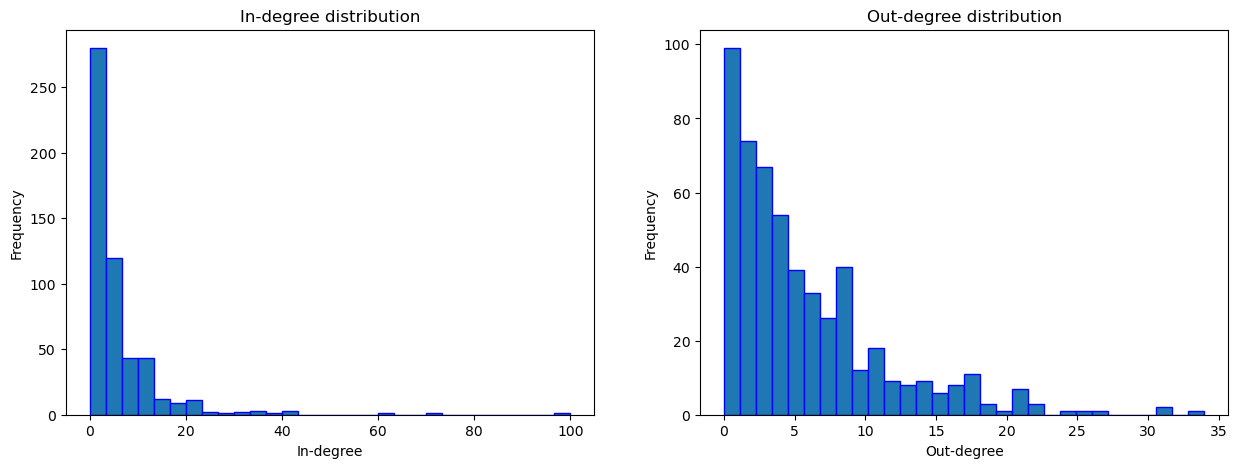

In [11]:
# Make histogram of in and out degree graph
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist([x[1] for x in in_degrees], bins=30, edgecolor='blue')
plt.title('In-degree distribution')
plt.xlabel('In-degree')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist([x[1] for x in out_degrees], bins=30, edgecolor='blue')
plt.title('Out-degree distribution')
plt.xlabel('Out-degree')
plt.ylabel('Frequency')
plt.show()

In [12]:
a_in = powerlaw.Fit([x[1] for x in in_degrees if x[1] != 0]).alpha
a_out = powerlaw.Fit([x[1] for x in out_degrees if x[1] != 0]).alpha

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


In [13]:
print("alpha- in degree:", f'{a_in:.3f}')
print("alpha- out degree:", f'{a_out:.3f}')

alpha- in degree: 3.075
alpha- out degree: 3.557


In [16]:
# draw the graph

color = []

for node in congress_graph.nodes():
    if congress_graph.nodes[node]['party'] == 'Republican':
        color.append('red')
    elif congress_graph.nodes[node]['party'] == 'Democratic':
        color.append('blue')
    else:
        color.append('green')

size = [degree*10 for node, degree in congress_graph.degree()]

# remove isolated nodes
#congress_graph.remove_nodes_from(list(nx.isolates(congress_graph)))

# remove self loops
#congress_graph.remove_edges_from(nx.selfloop_edges(congress_graph))

In [14]:
pos = nx.circular_layout(congress_graph)

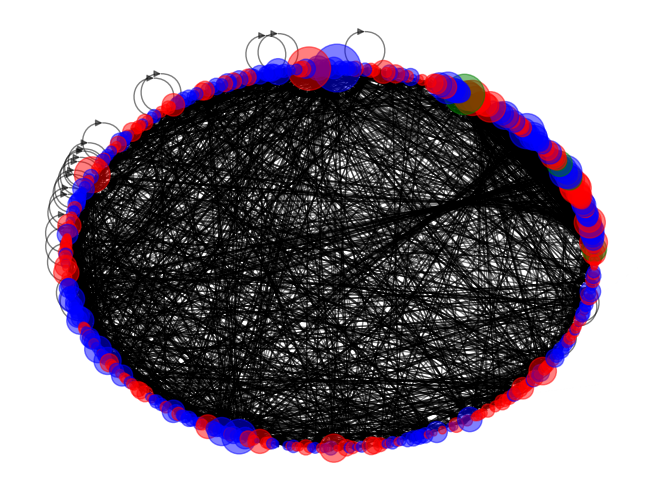

In [17]:
nx.draw(congress_graph, pos, font_size=8, node_color=color, node_size=size, alpha=0.5)

In [18]:
# create table with all the nodes stats
stats_df = pd.DataFrame()

for node in congress_graph.nodes():
    new_row = pd.DataFrame([[node, 
                            congress_graph.in_degree(node),
                            congress_graph.out_degree(node), 
                            nx.degree_centrality(congress_graph)[node]
                            ]])
    stats_df = pd.concat([stats_df,new_row], axis = 0, ignore_index=True)


# set the column names
stats_df.columns = ['Name', 'In-degree', 'Out-degree', 'Degree centrality']
print(stats_df)

                 Name  In-degree  Out-degree  Degree centrality
0    Tommy Tuberville          6           5           0.020677
1         Katie Britt          5           9           0.026316
2      Lisa Murkowski         14          12           0.048872
3        Dan Sullivan          0           0           0.000000
4      Kyrsten Sinema         14          18           0.060150
..                ...        ...         ...                ...
528  Scott Fitzgerald          0           0           0.000000
529    Glenn Grothman          1           1           0.003759
530       Tom Tiffany          2           1           0.005639
531    Mike Gallagher          0           0           0.000000
532   Harriet Hageman          2           4           0.011278

[533 rows x 4 columns]


In [19]:
# print nodes with highest degree centrality
print("Top 5 highest degree centrality:")
print(stats_df.sort_values(by=['Degree centrality'], ascending=False).head(10))

Top 5 highest degree centrality:
                         Name  In-degree  Out-degree  Degree centrality
131              Nancy Pelosi        100          18           0.221805
140            Kevin McCarthy         71          26           0.182331
88             Bernie Sanders         62          22           0.157895
228    Marjorie Taylor Greene         32          34           0.124060
62              Chuck Schumer         40          24           0.120301
85                   Ted Cruz         43          21           0.120301
370  Alexandria Ocasio-Cortez         35          27           0.116541
40           Elizabeth Warren         38          17           0.103383
94                Joe Manchin         21          31           0.097744
16                Marco Rubio         34          16           0.093985


Communities

In [ ]:
congress_graph_undirected = congress_graph.to_undirected()

In [ ]:
# Detect communities using the Python-Louvain algorithm
partition = community.best_partition(congress_graph_undirected, random_state = 1) # random state is a seed for reproducibility

Check how many communities 

In [ ]:
### Get number of communities in partition
num_communities = max(partition.values()) + 1
print(f'We have partitioned the network into {num_communities} communities. ')

We have partitioned the network into 92 communities. 


In [ ]:
### Get modularity of partition
print(f'The modularity of the partition is M = {community.modularity(partition, congress_graph_undirected)}')

The modularity of the partition is M = 0.4302380067072024


Now, let us visualize the sizes of the detected communities. First, we get a list of all communities. 

In [ ]:
### Get a list of all communities in list form
communities = [list() for _ in range(num_communities)]

for node, community_id in partition.items():
    communities[community_id].append(node)

### Sort communities from largest to smalles
communities = sorted(communities, key=len, reverse=True)

We now easily get the sizes of each community as

In [ ]:
community_sizes = [len(com) for com in communities]

Now, we can make a barchart to compare the sizes of the communities. 

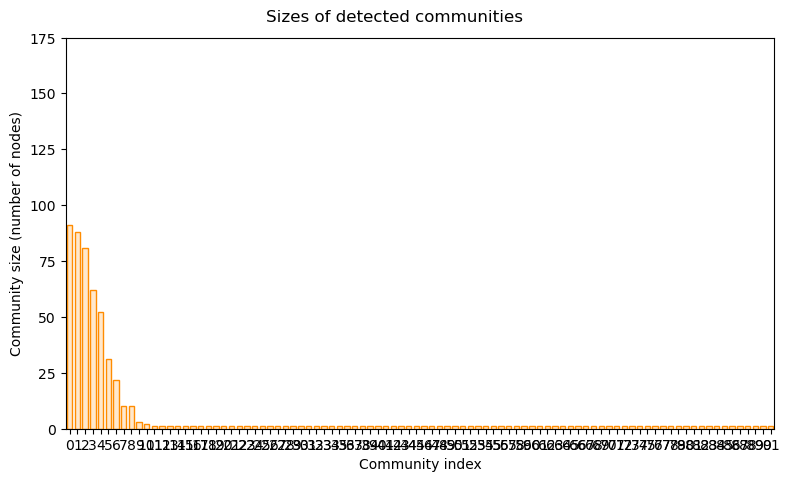

In [ ]:
orange1 = (255/255, 140/255, 0/255, 0.2)
orange2 = (255/255, 140/255, 0/255, 1)

fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle(r"Sizes of detected communities", size=12, y=0.955)

ax.set_ylabel('Community size (number of nodes)', size=10)
ax.set_xlabel('Community index', size=10) 

ax.bar([i for i in range(len(community_sizes))], community_sizes, width=0.7, fc=orange1, ec=orange2, lw=1)

ax.set_xticks([i for i in range(len(community_sizes))])
ax.set_xticklabels([i for i in range(len(community_sizes))], size=10)
ax.set_xlim(0-0.5, len(community_sizes)-0.5)

ax.set_yticks([25*i for i in range(8)])
ax.set_yticklabels([25*i for i in range(8)], size=10)

plt.tight_layout()

Plot the communties

Community sizes: [88, 1, 31, 81, 62, 1, 52, 22, 1, 10, 91, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


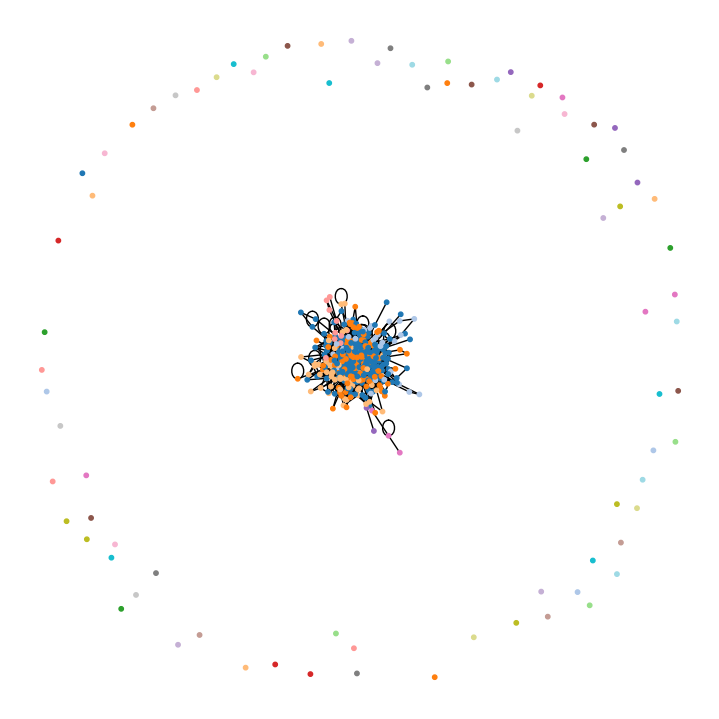

In [ ]:
# Get the community ID for each node
community_ids = list(partition.values())

# print community sizes
community_sizes = list(Counter(community_ids).values())
print("Community sizes:", community_sizes)

# Define a colormap for visualizing communities
colormap = plt.cm.get_cmap("tab20", max(community_ids) + 1)

# Map community IDs to colors
node_colors = [colormap(community_id) for community_id in community_ids]

# Draw the network graph with community-based node colors
plt.figure(figsize=(7, 7))
pos = nx.spring_layout(congress_graph_undirected, seed=42)
nx.draw(congress_graph_undirected, pos, node_color=node_colors, with_labels=False, node_size=10)
plt.show()

In [ ]:
republican_count = 0
democratic_count = 0
other_count = 0
community_idx = 0
republican_democratic_community_count = []

for com in communities:
    for node in com:
        ### Append count if rapper is from West Coast
        if congress_graph_undirected.nodes[node]['party'] == 'Republican':
            republican_count += 1
            
        ### Append count if rapper is from East Coast
        elif congress_graph_undirected.nodes[node]['party'] == 'Democratic':
            democratic_count += 1

        else:
            other_count += 1
    
    ### Append community index, count of West Coast-rappers and count of East Coast-rappers to community_count
    republican_democratic_community_count.append((community_idx, republican_count, democratic_count, other_count))
    
    ### Reset counts and update index
    republican_count = 0
    democratic_count = 0
    other_count = 0
    community_idx += 1

for v in republican_democratic_community_count:
    print(f'Community {v[0]} has {v[1]} Republicans, and {v[2]} Democrats and {v[3]} other')

Community 0 has 70 Republicans, and 21 Democrats and 0 other
Community 1 has 45 Republicans, and 38 Democrats and 5 other
Community 2 has 20 Republicans, and 61 Democrats and 0 other
Community 3 has 19 Republicans, and 43 Democrats and 0 other
Community 4 has 25 Republicans, and 27 Democrats and 0 other
Community 5 has 17 Republicans, and 14 Democrats and 0 other
Community 6 has 9 Republicans, and 13 Democrats and 0 other
Community 7 has 3 Republicans, and 7 Democrats and 0 other
Community 8 has 4 Republicans, and 6 Democrats and 0 other
Community 9 has 1 Republicans, and 2 Democrats and 0 other
Community 10 has 1 Republicans, and 1 Democrats and 0 other
Community 11 has 1 Republicans, and 0 Democrats and 0 other
Community 12 has 1 Republicans, and 0 Democrats and 0 other
Community 13 has 1 Republicans, and 0 Democrats and 0 other
Community 14 has 0 Republicans, and 1 Democrats and 0 other
Community 15 has 1 Republicans, and 0 Democrats and 0 other
Community 16 has 1 Republicans, and 0

In [ ]:
senators_count = 0
representatives_count = 0
community_idx = 0
senators_representatices_community_count = []

for com in communities:
    for node in com:
        ### Append count if rapper is from West Coast
        if node in senators_names:
            senators_count += 1
            
        ### Append count if rapper is from East Coast
        elif node in representatives:
            representatives_count += 1
    
    ### Append community index, count of West Coast-rappers and count of East Coast-rappers to community_count
    senators_representatices_community_count.append((community_idx, senators_count, representatives_count))
    
    ### Reset counts and update index
    senators_count = 0
    representatives_count = 0
    community_idx += 1

for v in senators_representatices_community_count:
    print(f'Community {v[0]} has {v[1]} senators and {v[2]} representatives')

Community 0 has 0 senators and 91 representatives
Community 1 has 83 senators and 5 representatives
Community 2 has 1 senators and 80 representatives
Community 3 has 1 senators and 61 representatives
Community 4 has 2 senators and 50 representatives
Community 5 has 8 senators and 23 representatives
Community 6 has 1 senators and 21 representatives
Community 7 has 1 senators and 9 representatives
Community 8 has 0 senators and 10 representatives
Community 9 has 0 senators and 3 representatives
Community 10 has 0 senators and 2 representatives
Community 11 has 1 senators and 0 representatives
Community 12 has 1 senators and 0 representatives
Community 13 has 0 senators and 1 representatives
Community 14 has 1 senators and 0 representatives
Community 15 has 0 senators and 1 representatives
Community 16 has 0 senators and 1 representatives
Community 17 has 0 senators and 1 representatives
Community 18 has 0 senators and 1 representatives
Community 19 has 0 senators and 1 representatives
Co

In [ ]:
sorted_partition = sorted(partition, key=len, reverse=True)
#print(sorted_partition)

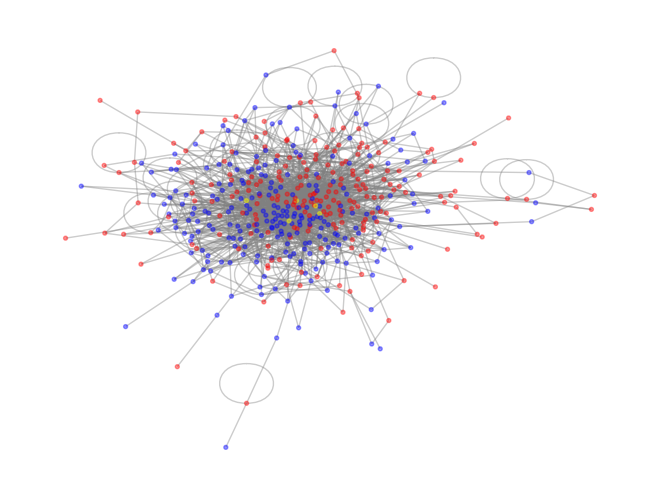

In [ ]:

congress_graph_undirected_new = congress_graph_undirected.copy()
# remove isolated nodes
congress_graph_undirected_new.remove_nodes_from(list(nx.isolates(congress_graph_undirected_new)))

# Create a list of colors for node visualization based on the 'coast' attribute
node_colors = ["red" if congress_graph_undirected_new.nodes[node]["party"] == "Republican" else "blue" if congress_graph_undirected_new.nodes[node]["party"] == "Democratic" else "yellow" for node in congress_graph_undirected_new.nodes()]


nx.draw(congress_graph_undirected_new, node_color = node_colors, with_labels=False, node_size=8, edge_color='gray', alpha=0.4)

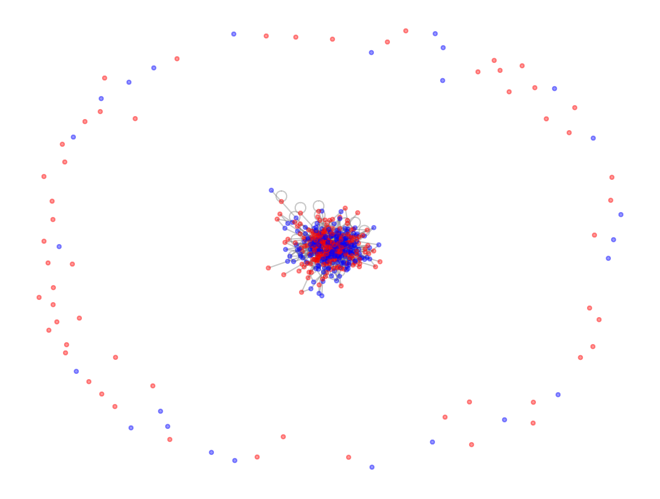

In [ ]:
node_colors = ["red" if congress_graph_undirected.nodes[node]["party"] == "Republican" else "blue" if congress_graph_undirected.nodes[node]["party"] == "Democratic" else "yellow" for node in congress_graph_undirected.nodes()]


nx.draw(congress_graph_undirected, node_color = node_colors, with_labels=False, node_size=8, edge_color='gray', alpha=0.4)

How many outliers are republicans or democrats?

In [ ]:
republican_count_total = 0
democratic_count_total = 0
other_count_total = 0

for v in republican_democratic_community_count[11:]:
    republican_count_total += v[1]
    democratic_count_total += v[2]
    other_count_total += v[3]

print(f'Total Republicans: {republican_count_total}')
print(f'Total Democrats: {democratic_count_total}')
print(f'Total other: {other_count_total}')


Total Republicans: 56
Total Democrats: 25
Total other: 0


In [ ]:
# defining a set of the first 10 communities


# defining a set of communties after the first 10
print(senate_df)

            State               Senator           Party  Age  \
0         Alabama      Tommy Tuberville      Republican   69   
1         Alabama           Katie Britt      Republican   41   
2          Alaska        Lisa Murkowski      Republican   66   
3          Alaska          Dan Sullivan      Republican   58   
4         Arizona        Kyrsten Sinema  Independent[d]   47   
..            ...                   ...             ...  ...   
95  West Virginia  Shelley Moore Capito      Republican   69   
96      Wisconsin           Ron Johnson      Republican   68   
97      Wisconsin         Tammy Baldwin      Democratic   61   
98        Wyoming         John Barrasso      Republican   71   
99        Wyoming        Cynthia Lummis      Republican   69   

                                        Occupation(s)  \
0   College football coach Investment management f...   
1   Senate staffer University administrator Lawyer...   
2                                              Lawyer   
3  

In [ ]:
total_republican_count = 0
total_democratic_count = 0
total_other_count = 0
total_age_republican = 0
total_age_democratic = 0
total_age_other = 0

for com in communities[11:]:  # Iterate over the last 80 communities
    republican_count = 0
    democratic_count = 0
    other_count = 0
    
    for node in com:
        # Check the party and accumulate counts and ages
        if congress_graph_undirected.nodes[node]['party'] == 'Republican':
            republican_count += 1
            try:
                total_age_republican += house_df[house_df['Member'] == node]['Age'].values[0]
            except:
                total_age_republican += senate_df[senate_df['Senator'] == node]['Age'].values[0]
        elif congress_graph_undirected.nodes[node]['party'] == 'Democratic':
            democratic_count += 1
            try:
                total_age_democratic += house_df[house_df['Member'] == node]['Age'].values[0]
            except:
                total_age_democratic += senate_df[senate_df['Senator'] == node]['Age'].values[0]
        else:
            other_count += 1
            try:
                total_age_other += house_df[house_df['Member'] == node]['Age'].values[0]
            except:
                total_age_other += senate_df[senate_df['Senator'] == node]['Age'].values[0]

    # Accumulate counts for each community
    total_republican_count += republican_count
    total_democratic_count += democratic_count
    total_other_count += other_count

# Calculate overall average age for Republicans and Democrats
avg_age_republican = total_age_republican / total_republican_count if total_republican_count > 0 else 0
avg_age_democratic = total_age_democratic / total_democratic_count if total_democratic_count > 0 else 0
avg_age_other = total_age_other / total_other_count if total_other_count > 0 else 0

# Print the results
print(f'Overall Average Age of Republicans: {avg_age_republican:.2f}')
print(f'Overall Average Age of Democrats: {avg_age_democratic:.2f}')
print(f'Overall Average Age of Others: {avg_age_other:.2f}')


Overall Average Age of Republicans: 58.39
Overall Average Age of Democrats: 60.28
Overall Average Age of Others: 0.00


In [ ]:
# general age average

# print the average age of republican politicians
print("Average age of republicans")
print(senate_df[senate_df['Party'] == 'Republican']['Age'].mean())
print(house_df[house_df['Party'] == 'Republican']['Age'].mean())

# print the average age of democratic politicians
print("Average age of democrats")
print(senate_df[senate_df['Party'] == 'Democratic']['Age'].mean())
print(house_df[house_df['Party'] == 'Democratic']['Age'].mean())

# print the average age of other politicians # only in senate
print("Average age of other (senate only)")
print(senate_df[(senate_df['Party'] != 'Democratic') & (senate_df['Party'] != 'Republican')]['Age'].mean())

Average age of republicans
63.08163265306123
56.828054298642535
Average age of democrats
64.47826086956522
58.448113207547166
Average age of other (senate only)
67.2


In [ ]:
total_republican_count = 0
total_democratic_count = 0
total_age_republican = 0
total_age_democratic = 0

for com in communities[:10]:  # Iterate over the last 80 communities
    republican_count = 0
    democratic_count = 0
    
    for node in com:
        # Check the party and accumulate counts and ages
        if congress_graph_undirected.nodes[node]['party'] == 'Republican':
            republican_count += 1
            try:
                total_age_republican += house_df[house_df['Member'] == node]['Age'].values[0]
            except:
                total_age_republican += senate_df[senate_df['Senator'] == node]['Age'].values[0]
        elif congress_graph_undirected.nodes[node]['party'] == 'Democratic':
            democratic_count += 1
            try:
                total_age_democratic += house_df[house_df['Member'] == node]['Age'].values[0]
            except:
                total_age_democratic += senate_df[senate_df['Senator'] == node]['Age'].values[0]

    # Accumulate counts for each community
    total_republican_count += republican_count
    total_democratic_count += democratic_count

# Calculate overall average age for Republicans and Democrats
avg_age_republican = total_age_republican / total_republican_count if total_republican_count > 0 else 0
avg_age_democratic = total_age_democratic / total_democratic_count if total_democratic_count > 0 else 0

# Print the results
print(f'Overall Average Age of Republicans: {avg_age_republican:.2f}')
print(f'Overall Average Age of Democrats: {avg_age_democratic:.2f}')


Overall Average Age of Republicans: 57.84
Overall Average Age of Democrats: 59.38


Calculate modularity bewteen republicans and democrats.

In [ ]:
import re
def extract_degrees(data):
    degrees = re.findall(r'\(([^)]*)\)', data)
    
    # split degrees if multiple degrees
    for d in degrees:
        if ',' in d:
            degrees.remove(d)
            degrees.extend(d.split(','))

    # if no degrees found, return empty list
    if len(degrees) == 0:
        degrees = ['none']
    return degrees

# extract name and education from dataframe
house_name_edu_df = house_df[['Member', 'Education']]
senate_name_edu_df = senate_df[['Senator', 'Education']]

# rename columns
house_name_edu_df.columns = ['Name', 'Education']
senate_name_edu_df.columns = ['Name', 'Education']

#concatenate the two dataframes
name_edu_df = pd.concat([house_name_edu_df, senate_name_edu_df], ignore_index=True)

# add copy of name column
name_edu_df['Degree'] = name_edu_df['Education']
name_edu_df['Degree'] = name_edu_df['Degree'].apply(extract_degrees)

In [ ]:
def extract_institution(data):
    # Use re.sub to replace the specified pattern in the data
    data = re.sub(r'\(([^)]*)\)', ",", data)

    # Split degrees if multiple degrees
    # Uncomment the next line if you want to split degrees based on commas
    data = [d for d in data.split(',')]

    # remove leading and trailing whitespace
    data = [d.strip() for d in data]

    # remove empty strings
    data = [d for d in data if d != '']

    return data

name_edu_df['Institution'] = name_edu_df['Education'].apply(extract_institution)

# print the number of politicians who have a degree from Harvard
print("Number of politicians who have a degree from Harvard")
counter = 0
for i in name_edu_df.iterrows():
    for j in i[1]['Institution']:
        if 'Harvard' in j:
            counter += 1
print(counter)

Number of politicians who have a degree from Harvard
50


In [ ]:
# obtain a list with all the institutions
institutions = []
for i in name_edu_df.iterrows():
    for j in i[1]['Institution']:
        institutions.append(j)
all_universities = set(institutions)

print("Number of unique institutions")
print(len(all_universities))

# create a dictionary with the names of politicians who have a degree from each institution
institutions_dict = {}
for i in all_universities:
    institutions_dict[i] = []

for i in name_edu_df.iterrows():
    for j in i[1]['Institution']:
        institutions_dict[j].append(i[1]['Name'])

Number of unique institutions
500


In [ ]:
all_degrees = []
for i in name_edu_df.iterrows():
    for j in i[1]['Degree']:
        # remove leading and trailing whitespace
        j = j.strip()
        all_degrees.append(j)

all_degrees = set(all_degrees)

# make similar dictionary with the degrees
uni_degrees_dict = {}
for i in all_degrees:
    uni_degrees_dict[i] = []

for i in name_edu_df.iterrows():
    for j in i[1]['Degree']:
        name = i[1]['Name']
        uni_degrees_dict[j.strip()].append(name)

print(uni_degrees_dict)

{'MSS': ['Jeanne Shaheen'], 'MPA': ['Mike Rogers', 'Mike Thompson', 'Kevin Mullin', 'Maria Elvira Salazar', 'Randy Feenstra', 'Jim McGovern', 'Katherine Clark', 'Stephen F. Lynch', 'John Moolenaar', 'Brian Higgins', 'Dusty Johnson', 'Dan Crenshaw', 'Jodey Arrington', 'Wesley Hunt', 'Gerry Connolly', 'Rick Larsen', 'Joni Ernst', 'Sherrod Brown', 'Jeff Merkley'], 'MSc': ['Mikie Sherrill', 'Jon Ossoff'], 'PharmD': ['Diana Harshbarger'], 'MAcc': ['Victoria Spartz'], 'JD': ['Mike Rogers', 'Robert Aderholt', 'Terri Sewell', 'Greg Stanton', 'Andy Biggs', 'Jared Huffman', 'Kevin Kiley', 'Eric Swalwell', 'Ro Khanna', 'Zoe Lofgren', 'Jimmy Panetta', 'Adam Schiff', 'Brad Sherman', 'Ted Lieu', 'Linda Sanchez', 'Nanette Barragan', 'Lou Correa', 'Katie Porter', 'Mike Levin', 'Scott Peters', 'Juan Vargas', 'Diana DeGette', 'Joe Neguse', 'Ken Buck', 'Doug Lamborn', 'Jason Crow', 'Yadira Caraveo', 'Joe Courtney', 'Matt Gaetz', 'Darren Soto', 'Gus Bilirakis', 'Kathy Castor', 'Laurel Lee', 'Greg Steube',

## Wordclouds

In [ ]:
from collections import defaultdict, Counter

In [ ]:
politician_communities = {politician: community_id for politician, community_id in partition.items()}
print(politician_communities)

In [ ]:
# Create a nested dictionary. Outer key is the community id and the inner key is the politicians name.
#Each inner value will be a list of cleaned tokens
community_politicians_tokens = defaultdict(lambda: defaultdict(list))

In [ ]:
senators_directory = #path to senators
representatives_directory = #path to representatives

In [ ]:
from nltk.tokenize import word_tokenize
import string
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords data (do this once)
nltk.download('stopwords')

# Get English stopwords
stop_words = set(stopwords.words('english'))

#Funtion to tokenize, and clen the wiki texts
def cleaned_politician_texts(text):
    if not isinstance(text, str):
        return []  # Return an empty list if text is not a string

    #print(f"Original Text: {text}")

    tokens = word_tokenize(text)
    #print(f"Tokens after tokenization: {tokens}")

    clean_tokens = []

    for token in tokens:
        # Convert to lowercase
        token = token.lower()

        # Remove punctuation and stopwords
        if token not in string.punctuation and token not in stopwords.words('english'):
            clean_tokens.append(token)

    #print(f"Cleaned Tokens: {clean_tokens}")
    return clean_tokens

In [ ]:
# Load texts for senators
for filename in os.listdir(senators_directory):
    if filename.endswith('.txt'):
        politician_name = os.path.splitext(filename)[0]  # Remove the '.txt' extension
        file_path = os.path.join(senators_directory, filename)
        
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            cleaned_text = cleaned_politician_texts(text)

            # Get the community ID for the politician
            community_id = partition.get(politician_name, "N/A")

            # Store the cleaned tokens under the corresponding community and politician
            community_politicians_tokens[community_id][politician_name].extend(cleaned_text)



# Load texts for representatives
for filename in os.listdir(representatives_directory):
    if filename.endswith('.txt'):
        politician_name = os.path.splitext(filename)[0]  # Remove the '.txt' extension
        file_path = os.path.join(representatives_directory, filename)
        
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            cleaned_text = cleaned_politician_texts(text)

            # Get the community ID for the politician
            community_id = partition.get(politician_name, "N/A")

            # Store the cleaned tokens under the corresponding community and politician
            community_politicians_tokens[community_id][politician_name].extend(cleaned_text)

In [ ]:
# Print each politician and their communitiy as well as the tokenized and cleaned text
for community, politicians in community_politicians_tokens.items():
    for politician, tokens in politicians.items():
        print(f'Community: {community}, Politician: {politician}, Cleaned Tokens: {tokens}')

In [ ]:
# Create a dictionary to store frequency lists for each community
community_frequency_lists = defaultdict(dict)

# Create frequency lists for each community
for community, politicians in community_politicians_tokens.items():
    aggregated_tokens = [token for tokens in politicians.values() for token in tokens]
    frequency_list = Counter(aggregated_tokens)
    community_frequency_lists[community] = frequency_list

# Print community_frequency_lists 
for community, frequency_list in community_frequency_lists.items():
    print(f'Community: {community}, Frequency List: {frequency_list}')

In [ ]:
# Create a dictionary to store ratio lists for each community
community_ratio_lists = defaultdict(dict)

# Add a constant to avoid division by zero
constant = 1

# Calculate ratio lists for each community
for current_community, current_frequency_list in community_frequency_lists.items():
    other_communities = [c for c in community_frequency_lists if c != current_community]

    for word, frequency in current_frequency_list.items():
        total_frequency_other_communities = sum(community_frequency_lists[c][word] for c in other_communities) + constant
        ratio = frequency / total_frequency_other_communities

        # Store the ratio for the word in the current community
        community_ratio_lists[current_community][word] = ratio

# Print community_ratio_lists
for community, ratio_list in community_ratio_lists.items():
    print(f'Community: {community}, Ratio List: {ratio_list}')

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to create and display word clouds for each community
def generate_wordclouds(community_ratio_lists, output_directory='wordclouds'):
    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)

    for community, ratio_list in community_ratio_lists.items():
        if community == "N/A":
            continue

        # Sort the ratio list by value in descending order
        sorted_ratio_list = sorted(ratio_list.items(), key=lambda x: x[1], reverse=True)

        # Create a WordCloud object
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(sorted_ratio_list))

        # Plot the WordCloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for Community {community}')
        plt.axis('off')

        # Save the plot
        save_path = os.path.join(output_directory, f'wordcloud_community_{community}.png')
        plt.savefig(save_path, bbox_inches='tight')

        # Show the plot
        plt.show()

# Generate and display word clouds for each community
generate_wordclouds(community_ratio_lists)